In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import cv2
import mmcv
import pickle as pk
import os, sys
sys.path.insert(0, '/workspaces/mmhuman3d')

In [2]:
# def generate_heatmap(heatmap, sigma):

#     shape = heatmap.shape
# #     print(shape)
#     tmp_size = sigma * 3           # 这里控制高斯核大小，可改为你想要的高斯核大小
#     mu_x = 0            # x坐标
#     mu_y = 32            # y坐标
#     ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]           # 关键点高斯分布左上角坐标，[18，26］
#     br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]   # 关键点高斯分布右下角坐标，[31，39］
#     size = 2 * tmp_size + 1              # 高斯核大小
#     x = np.arange(0, size, 1, np.float32)
#     y = x[:, np.newaxis]
#     x0 = y0 = size // 2       # 6
#     g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
# #     print(g)
#     g_x = max(0, -ul[0]), min(br[0], shape[0]) - ul[0]   # (0,13) 差值为2 * tmp_size + 1，即size大小
#     g_y = max(0, -ul[1]), min(br[1], shape[1]) - ul[1]   # (0,13)
#     img_x = max(0, ul[0]), min(br[0], shape[0])   # (26,39)
#     img_y = max(0, ul[1]), min(br[1], shape[1])   # (18,31)
#     heatmap[img_x[0]:img_x[1], img_y[0]:img_y[1]] = g[g_x[0]:g_x[1], g_y[0]:g_y[1]]
# #     heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
#     am = np.amax(heatmap)
#     heatmap /= am / 255
#     return heatmap


# target = np.zeros((64, 48))    # h，w
# sigma = 2
# plt.imshow(target, cmap='hot', interpolation='nearest')
# plt.show()
# target = generate_heatmap(target, sigma)
# plt.imshow(target, cmap='hot', interpolation='nearest')
# plt.show()                # 显示图像
# # print(target)


In [2]:
def gen_heatmap(heatmap_size, image_size, joints):
    
    sigma = 15
    tmp_size = sigma * 3
    num_joints = len(joints)
    
    # target: [num_joints, heatmap_size, heatmap_size]
    target = np.zeros((num_joints, heatmap_size[0], heatmap_size[1]), dtype=np.float32)
    # target_weight: [num_joints, 1] (1-dim, 1:visible, 0:invisible)
    target_weight = np.ones((num_joints,1), dtype=np.float32)
    
    # 生成一张图像的heatmap
    for joint_id in range(num_joints):
        feat_stride = image_size / heatmap_size
        # 高斯核中心在热力图上的位置
        mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
        mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
        # gaussian range, ul:left-top, br:right-down
        ul = [int(mu_x-tmp_size), int(mu_y-tmp_size)]
        br = [int(mu_x+tmp_size+1), int(mu_y+tmp_size+1)]
        # 这一段貌似没有什么用
        if ul[0] > heatmap_size[0] or ul[1] >= heatmap_size[1] or br[0] < 0 or br[1] < 0:
            target_weight[joint_id] = 0
            continue
        
        # gaussian kernel size
        size = 2 * tmp_size + 1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        # 高斯分布 z = e^(-((x-x0)^2+(y-y0)^2) / (2*σ^2)）
        g = np.exp(-((x-x0)**2+(y-y0)**2) / (2*sigma**2) ) 
        g_x = max(ul[0], 0)-ul[0], min(br[0], image_size[0])-ul[0]
        g_y = max(ul[1], 0)-ul[1], min(br[1], image_size[1])-ul[1]
        # image range
        img_x = max(ul[0], 0) , min(br[0], image_size[0])
        img_y = max(ul[1], 0) , min(br[1], image_size[1])
        
        # select confident joints
        v = target_weight[joint_id]
        if v > 0.5:
            target[joint_id][img_x[0]:img_x[1] , img_y[0]:img_y[1]] \
                = g[g_x[0]:g_x[1] , g_y[0]:g_y[1]]
        
    return target
            

# main
# joints = np.array([[100, 60, 1], [100, 10, 1]])
# heatmap_size = np.array([154, 81])
# image_size = np.array([154, 81])
# heatmap = gen_heatmap(heatmap_size, image_size, joints)
# print(heatmap.shape)

# heatmap = heatmap[0]
# am = np.amax(heatmap)
# heatmap /= am / 255
# plt.imshow(heatmap, cmap='hot', interpolation='nearest')
# plt.show()

[[ 965.766  173.2  ]
 [ 962.88   278.857]
 [ 872.18   281.756]
 [ 854.722  437.269]
 [ 854.52   569.397]
 [1044.95   275.938]
 [1065.41   428.447]
 [1079.93   551.802]
 [ 919.031  557.568]
 [ 927.811  754.268]
 [ 954.182  944.964]
 [1021.57   551.759]
 [1015.65   757.079]
 [1001.     936.21 ]
 [ 945.415  155.599]
 [ 974.733  155.593]
 [ 921.965  173.268]
 [ 998.156  173.092]]
(1080, 1920)
(1080, 1920)


<IPython.core.display.Javascript object>


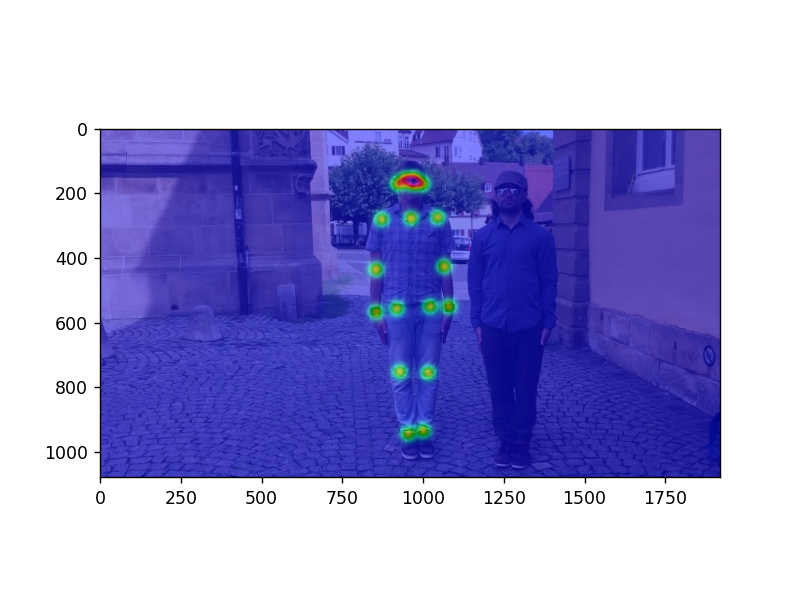

True

In [4]:
index = 0
fname = '/workspaces/mmhuman3d/data/datasets/pw3d/sequenceFiles/test/downtown_arguing_00.pkl'
with open(fname, 'rb') as f:
    context = pk.load(f, encoding='latin1')
poses2d = context['poses2d'][0][index, :]
poses2d = poses2d.transpose(1,0)[:,:2]
print(poses2d)

imagefile = f'/workspaces/mmhuman3d/data/datasets/pw3d/imageFiles/downtown_arguing_00/image_{str(index).zfill(5)}.jpg'
img = cv2.imread(imagefile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(img.shape[:2])
heatmap_size = np.array(img.shape[:2])
image_size = np.array(img.shape[:2])
joints = np.array(poses2d[:,[1,0]])
heatmap = gen_heatmap(heatmap_size, image_size, joints)
heatmap = np.mean(heatmap, axis=0)
print(heatmap.shape)

am = np.amax(heatmap)
heatmap /= am / 255
# plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
# plt.show()
heatmap = cv2.applyColorMap(np.uint8(heatmap), cv2.COLORMAP_HSV)
img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

# 遍历所有点，并在图像上绘制圆形
# for point in poses2d:
#     cv2.circle(img, point.astype(int), 10, (0, 0, 255), -1)
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('/workspaces/mmhuman3d/workspace/demo/1.png', img)

[[ 965.766  173.2  ]
 [ 962.88   278.857]
 [ 872.18   281.756]
 [ 854.722  437.269]
 [ 854.52   569.397]
 [1044.95   275.938]
 [1065.41   428.447]
 [1079.93   551.802]
 [ 919.031  557.568]
 [ 927.811  754.268]
 [ 954.182  944.964]
 [1021.57   551.759]
 [1015.65   757.079]
 [1001.     936.21 ]
 [ 945.415  155.599]
 [ 974.733  155.593]
 [ 921.965  173.268]
 [ 998.156  173.092]]


<IPython.core.display.Javascript object>


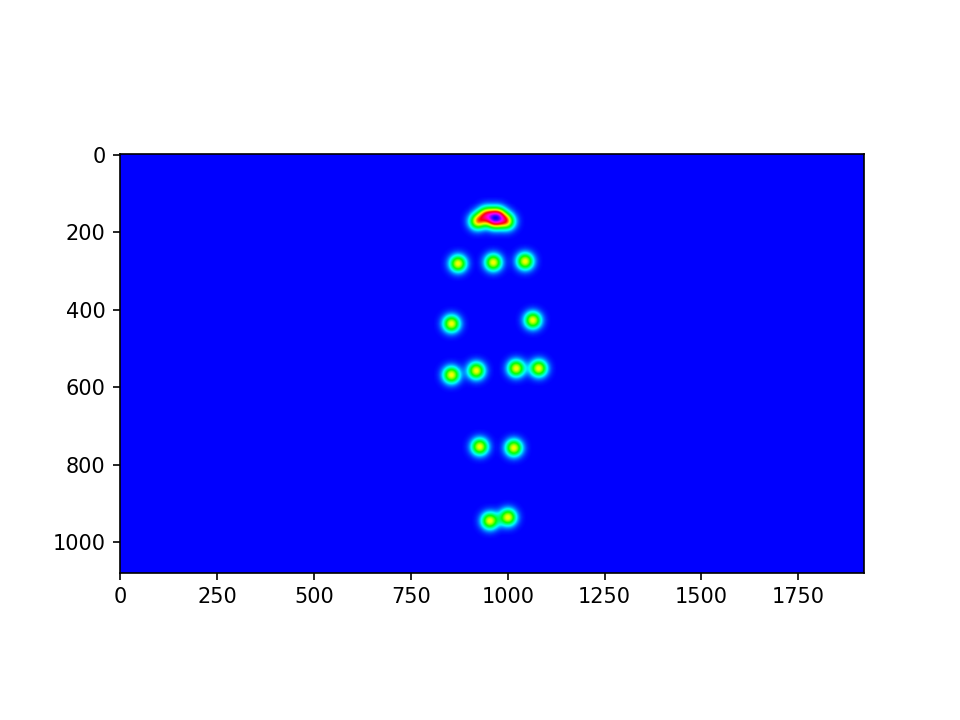

True

In [3]:
index = 0
fname = '/workspaces/mmhuman3d/data/datasets/pw3d/sequenceFiles/test/downtown_arguing_00.pkl'
with open(fname, 'rb') as f:
    context = pk.load(f, encoding='latin1')
poses2d = context['poses2d'][0][index, :]
poses2d = poses2d.transpose(1,0)[:,:2]
print(poses2d)

heatmap_size = np.array([1080, 1920])
image_size = np.array([1080, 1920])
joints = np.array(poses2d[:,[1,0]])
heatmap = gen_heatmap(heatmap_size, image_size, joints)
heatmap = np.mean(heatmap, axis=0)

am = np.amax(heatmap)
heatmap /= am / 255
heatmap = cv2.applyColorMap(np.uint8(heatmap), cv2.COLORMAP_HSV)
plt.imshow(heatmap)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR)
cv2.imwrite('/workspaces/mmhuman3d/workspace/demo/2.png', heatmap)